In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime
from dateutil.relativedelta import relativedelta

from cartopy import crs as ccrs, feature as cfeature
import warnings
warnings.filterwarnings('ignore')

# import netCDF4
# from netCDF4 import Dataset

import xarray as xr
import glob, os
#print(xr.__version__)

In [35]:
filename = '/d6/bxw2101/ersst_monthly/all_sst.nc'
sst_ds = xr.open_dataset(filename, decode_times=False)
filename = '/d6/bxw2101/ersst_monthly/all_sst_anom.nc'
anomsst_ds = xr.open_dataset(filename, decode_times=False)

date_1 = datetime.datetime.strptime("01/01/1960", "%m/%d/%Y")
def convert_times(x):
  return date_1 + relativedelta(months=int(x))
convert_times_v = np.vectorize(convert_times)

sst_ds = sst_ds.assign_coords(T=convert_times_v(sst_ds.T))
sst_ds = sst_ds.rename({'T': 'tdim'})
anomsst_ds = anomsst_ds.assign_coords(T=convert_times_v(anomsst_ds.T))
anomsst_ds = anomsst_ds.rename({'T': 'tdim'})

In [36]:
sst_ds_crop = sst_ds.sel(Y=slice(-88, -50))
sst_ds_crop = sst_ds_crop.sel(tdim=slice('1979-01-01', '2021-12-01'))
sst_var = sst_ds_crop.sst
# Y: 20
# X: 180. Pretty damn coarse 2degx2deg cells. We got a 20x180 grid. 
anomsst_ds_crop = anomsst_ds.sel(Y=slice(-88, -50))
anomsst_ds_crop = anomsst_ds_crop.sel(tdim=slice('1979-01-01', '2021-12-01'))
anom_var = anomsst_ds_crop.anom
#print(sst_ds_crop.Y.values)
#print(sst_ds_crop.X.values)

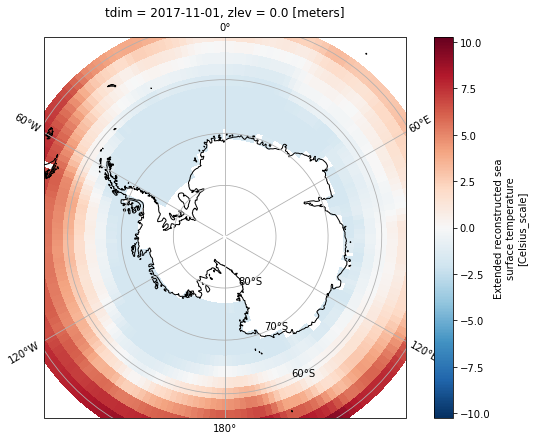

In [37]:
# SST Values, graphed.
arb_time = sst_var.sel(tdim='2017-11-01')

sp = ccrs.SouthPolarStereo()
pc = ccrs.PlateCarree() # The OG Data is in pc projection.

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
arb_time.plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

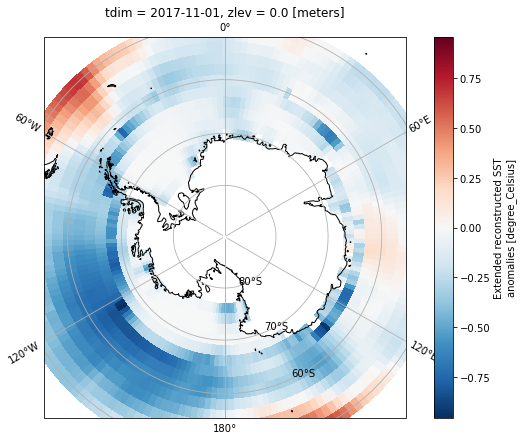

In [5]:
## their Anomaly values, graphed.
anom1 = anom_var.sel(tdim='2017-11-01')

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
anom1.plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

## Climatology, anomaly dataset, and my calculated anomaly. sst_anom, datasetatom are the two dataarrays.

In [38]:
#Manually gonna calculate the anomaly. Climatology here will be 1971-2021
sst_mon = sst_var.groupby('tdim.month')
sst_clim = sst_mon.mean(dim='tdim')
sst_anom = sst_mon - sst_clim

sst_anom_ds = xr.Dataset(data_vars = {"sst_anom": sst_anom})
sst_anom_ds = sst_anom_ds.sel(zlev=0.0).drop_vars('zlev')
sst_anom_ds = sst_anom_ds.drop_vars('month')
clean_sst_ds = sst_anom_ds.transpose("tdim", "Y" , "X")


diff_anom = sst_anom - anom_var; #this should be all zeroes if things are the same.
#Apparently my anomaly from the monthly means and the anomaly dataset is different despite having the same climatology...

In [19]:
clean_sst_ds.to_netcdf('/d6/bxw2101/combined_netcdf_files/sst_anom_monthly_2x2.nc', mode='w',format='NETCDF4')

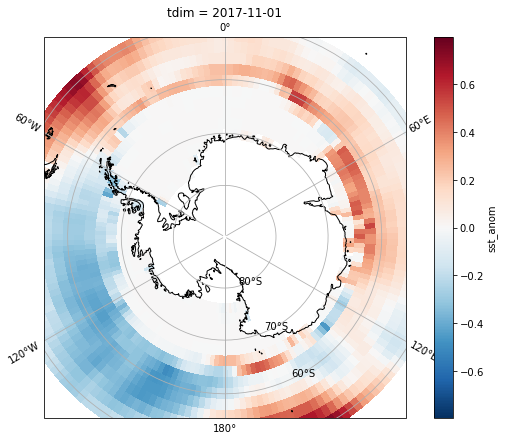

In [20]:
anom3 = clean_sst_ds.sst_anom.sel(tdim='2017-11-01')

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection=sp)
anom3.plot(transform=pc) #arb_time.plot(ax=ax,  vmin=0, vmax=1, cmap='coolwarm')
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-3950000., 3950000., 4350000., -3950000.], crs=sp)

## Getting 1979-2000 data

In [39]:
o_sst_var = sst_var.isel(tdim=slice(0, 264))

In [40]:
#Manually gonna calculate the anomaly. Climatology here will be 1971-2021
o_sst_mon = o_sst_var.groupby('tdim.month')
o_sst_clim = o_sst_mon.mean(dim='tdim')
o_sst_anom = o_sst_mon - o_sst_clim

o_sst_anom_ds = xr.Dataset(data_vars = {"sst_anom": o_sst_anom})
o_sst_anom_ds = o_sst_anom_ds.sel(zlev=0.0).drop_vars('zlev')
o_sst_anom_ds = o_sst_anom_ds.drop_vars('month')
o_clean_sst_ds = o_sst_anom_ds.transpose("tdim", "Y" , "X")

In [42]:
o_clean_sst_ds.to_netcdf('/d6/bxw2101/o_combined_netcdf_files/o_sst_anom_monthly_2x2.nc', mode='w',format='NETCDF4')

### Some random code from when I needed to learn what I was doing

In [ ]:
# Graphs to compare
mean_sst_var = sst_var.mean(dim=['X','Y'])
mean_sst_var.plot(size=7, label="unweighted")
#mean_sst_var.rolling(tdim=5, center=True).mean().plot()
sst_weighted.mean(dim=['X','Y']).plot(label="weighted")
plt.legend()

#My anomaly: comparing to the climate monthly MEANS.
# for now: testing to see how tf these people get their anoms. so i used 1971-2000 as my climatology too.
mean_sst_anom = sst_anom.mean(dim=['X', 'Y'])
mean_sst_anom.plot(size=7)
mean_sst_anom.rolling(tdim=5, center=True).mean().plot()


#Anomaly dataset: uses 1971-2000 as the climatology. but is it a sin func or some shit?? how???
datasetanom = anom_var.mean(dim=['X', 'Y'])
datasetanom.plot(size=7)
datasetanom.rolling(tdim=5, center=True).mean().plot()
# They are SIMILAR but not quite the same.

# Comparing my anomaly with the dataset anomaly.
mean_sst_anom.plot(size=7, label="recalculated anomaly")
datasetanom.plot(label="dataset anomaly")
#anom_weighted.mean(dim=['X','Y']).plot()
plt.legend()